# Synchronization Procedure Demo
mardis@uni-bremen.de

In [4]:
import numpy as np
from matplotlib import pylab
from matplotlib import pyplot as plt

from pyphysim import channels
from pyphysim.channels.fading import TdlChannel
from pyphysim.channels.fading_generators import JakesSampleGenerator
from pyphysim.modulators import OFDM, PSK, QAM
from pyphysim.modulators.ofdm import OfdmOneTapEqualizer
from pyphysim.util.misc import randn_c, calc_autocorr
from pyphysim.util.conversion import linear2dB

In [5]:
# Parameters

## seed for reproducability
np.random.seed(1)


# Physical layer cell identity

N_ID1 = 111 %336   # cell ID group {0,..,335}
N_ID2 = 0 %3       # cell ID sector {0,1,2}
N_ID_Cell = 3*N_ID1 + N_ID2     # cell identity ID


## OFDM Parameters
SCS = 15e3
# bw = 
# etc.


## Band
n1 = {
    'UL_lo' : 1920e6,    # UL low end [Hz]
    'UL_B' : 60e6,       # UL bandwidth [Hz]
    'DL_lo' : 2110e6,    # DL low end [Hz]
    'DL_B' : 60e6,       # DL bandwidth [Hz]
}

band = n1
FR = 1


## SSB Parameters (38.211 Table 7.4.3.1-1)
ssb_dim = {
    'l' : 4,
    'k' : 240,
    'k0_pss' : 56,
    'k_pss' : 127,
    'l0_pss' : 0,
    'k0_sss' : 56,
    'k_sss' : 127,
    'l0_sss' : 2,
    'l0_pbch' : (1,3),
    'nu' : N_ID_Cell % 4
    #todo pbch dmrs dims
    
}

ssb = np.ones((ssb_dim['k'], ssb_dim['l'])) * -10 # false color 
ssb = np.zeros((ssb_dim['k'], ssb_dim['l']))

bbch_bch = np.concatenate((        # mib + messageClassExtension
    np.random.randint(2,size = 6), # SystemFrameNumber
    np.random.randint(2,size = 1), # subCarrierSpacingCommon
    np.random.randint(2,size = 4), # ssb-SubcarrierOffset
    np.random.randint(2,size = 1), # dmrs-typeA-Position 
    np.random.randint(2,size = 8), # pdcch-ConfigSIB1
    np.random.randint(2,size = 1), # cellBarred
    np.random.randint(2,size = 1), # intraFreqReselection
    [0],                           # spare
    [0],                           # messageClassExtension typically added later in pbch transport process
))

if not len(bbch_bch) == 24:
    raise ValueError('BBCH-BCH is always 24 bits')

L__max = 10 # todo ?

## Antenna Models
Tx = {
    'M_g' : 1,    # number of panels in a column
    'N_g' : 1,    # number of panels in a row
    'M': 8,       # number of antenna elements with the same polarization in each column
    'N' : 8,      # number of antenna elements with the same polarization in each row
    'P' : 2       # antenna panel is either single polarized (P=1) or dual polarized (P=2)
}

Rx = {
    'M_g' : 1,    # number of panels in a column
    'N_g' : 1,    # number of panels in a row
    'M': 2,       # number of antenna elements with the same polarization in each column
    'N' : 2,      # number of antenna elements with the same polarization in each row
    'P' : 2       # antenna panel is either single polarized (P=1) or dual polarized (P=2)
}

# Channel Model

# Synchronization Signal Block Generation

In [62]:
def pss(n, x):
    d_pss = []
    
    if not len(x) == 7:
        raise ValueError('PSS must be initialized with 7 bits')
    
    for i in range(n-len(x)):
        x.append(
            (x[i+4] + x[i]) % 2)
    
    for n_i in range(n):
        d_pss.append( 
            1 - 2 * x[(n_i + 43 * N_ID2) % 127])
        
    return d_pss

def sss(n, x_0, x_1):
    d_sss = []
    m_0 = 15*(N_ID1//112) + 5 * N_ID2
    m_1 = N_ID1 % 112
    
    if not len(x_0) == 7 or not len(x_1) == 7:
        raise ValueError('SSS x_0 and x_1 must be initialized with 7 bits')
    
    for i in range(n-len(x_0)):
        x_0.append(
            (x_0[i+4] + 4 * x_0[i] ) % 2)
        x_1.append(
            (x_1[i+1] + x_1[i]) % 2)
    
    for n_i in range(n):
        d_sss.append(
            (1 - 2 * x_0[(n_i + m_0) % 127]) *
            (1 - 2 * x_1[(n_i + m_1) % 127]))
        
    return d_sss

def dmrs():
    pass

def pbch(a_):
    
    # PBCH payload generation 38.212 7.1.1
    ## todo  a_0 is mapped to the most significant bit of the transport block?
    A_ = len(a_)
    a = np.concatenate(a_, np.random.randint(2, size = 8)) # a_A_ to a_A_+7 are timing related PBCH payload from higher layers
    A = len(a)
    ## shuffle array instead of using interleaver pattern as per Table 7.1.1-1
    ## todo
    a = np.random.shuffle(a)
    
    
    # L1 scrambling 38.212 7.1.2
    s = np.array(2, size = A)
    j = 0
    M = 0
    if L__max == 4 or L__max == 8:
        M = A - 3
    elif L__max == 10:
        M = A - 4
    elif L__max == 20:
        M = A - 5
    elif L__max == 64:
        M = A - 6
    v = np.random.randint(4)
    c_init = N_ID_Cell
    # 38.211 5.2.1 Pseudo-random sequence generation
    def prsg(M_PN):
        c = np.zeros(M_PN)
        x_1 = np.concatenate([1], np.zeros(30))
        x_2 = np.array(np.flip([int(x) for x in bin(10)[2:]]))
        x_2.resize((31))
        N_c = 1600
        for n in range(M_PN - 31 ):
            x_1.append( (x_1[n+3] + x_1[n]) % 2 )
            x_2.append( (x_2[n+3] + x_2[n+2] + x_2[n+1] + x_2[n]) % 2)
            if len(x_1) == M_PN or len(x_2) == M_PN:
                break
        for n in range(c):
            c[n] = (x_1[n + N_c] + x_2[n + N_c]) % 2
        return c
    c = prsg(A + v * M)
    
    for i in range(A):
        ### a corresponds to any one of the bits belonging to the candidate SS/PBCH 
        ### block index, the half frame index, and 2nd and 3rd least significant 
        ### bits of the system frame number 
        ### todo
        if np.random.randint(8) == 0:
            s[i] = 0
        else:
            s[i] = c[j + v * M]
            
    a_ = np.zeros(A) # scrambled sequence a' = a_, python syntax
    for i in range(A):
        a_[i] = (a[i] + s[i]) % 2
    del j 
    
    # CRC attachment 38.212 7.1.3 
    p = np.zeros(len(a_))
    ## CRC calculation 38.212 5.1
    def g_CRC24C():
                        #24,23,   21, 20,      17,   15,  13, 12,   8,          4,    2, 1, 0   
        gen_polynomial = [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
        
        
    # channel coding
    # rate matching
    return f

#38.211 7.4.3.1.3
def map_pbch():
    pass


SyntaxError: invalid syntax (<ipython-input-62-8794189417de>, line 94)

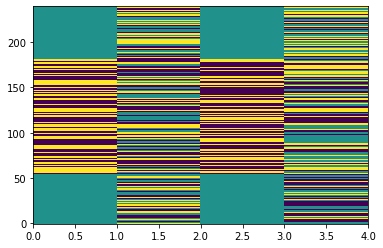

In [85]:
# pss mapping
ssb[
    ssb_dim['k0_pss']:ssb_dim['k0_pss'] + ssb_dim['k_pss'],
    ssb_dim['l0_pss']] = pss(
    n = 127,
    x = [1, 0, 0, 0, 0, 0, 0])

# sss mapping
ssb[
    ssb_dim['k0_sss']:ssb_dim['k0_sss'] + ssb_dim['k_sss'],
    ssb_dim['l0_sss']] = sss(
    n = 127,
    x_0 = [0, 0, 0, 0, 0, 0, 1],
    x_1 = [0, 0, 0, 0, 0, 0, 1])

#pbch todo

for i in range(len(ssb_dim['l0_pbch'])):
    ssb[
        0:ssb_dim['k'],
        ssb_dim['l0_pbch'][i]] = np.random.randint(3, size=ssb_dim['k'])-1


    
fig, ax = plt.subplots()
ax.pcolormesh(np.array(range(len(ssb[0]))) + 0.5, range(len(ssb)), ssb, shading='auto')